# Relaxed Solver for Dynamic Unbalanced Optimal Transport

In this notebook, we check the behavior of `dynamic_wfr_relaxed_grid` function which solves the unbalanced dynamic OT problem on a rectangular grid.

In [44]:
# Import relevant libraries
import sys
import torch
sys.path.append('../relaxed')
from dynamic_wfr_relaxed import wfr_grid, wfr_grid_scipy, wfr_grid_scipy_tunerel
import numpy as np
import matplotlib.pyplot as plt

def plot_pvz_1D(p: torch.Tensor,
                v: torch.Tensor = None,
                z :torch.Tensor = None,
                dx: list = None,
                p2: torch.Tensor = None):
    """Plots the change of p, v and z over time on 1D. \
        We plot the graph assuming that the i,j element represents the value at\
        t=i/T, x=j*dx.
    
    p (torch.Tensor of shape (T + 1, N)) : The mass density.

    v (torch.Tensor of shape (T, N, 1)) : The velocity field.

    z (torch.Tensor of shape (T, N)) : The source field.

    dx (list of a single float) : The list containing the space step. \
    If None, we assume that dx = [1/N].

    p2 (torch.Tensor) : The terminal density. If given, we plot the terminal \
    density at each time.

    """
    time_steps = p.shape[0]
    space_steps = p.shape[-1]
    if dx is None:
        dx = [1.0/space_steps]

    xs = np.arange(0, space_steps*dx[0], dx[0])
    
    X, Y = np.meshgrid(xs, np.zeros_like(xs))

    for time_step in range(time_steps):
        plt.figure(figsize=(10, 6))
        plt.plot(xs, p[time_step], label = 'Density')
        if p2 is not None and time_step == time_steps-1:
            plt.plot(xs, p2, color='r', label = 'Terminal Dist')
        
        if time_step < time_steps-1:
            if v is not None:
                U = np.tile(v[time_step].squeeze(), (1, space_steps))
                V = np.zeros_like(X)
                plt.quiver(X, Y, U/np.sqrt(U**2), V, cmap='jet')
            if z is not None:
                plt.plot(xs, z[time_step], color='c', label = 'Source')

        plt.title(f't={time_step/(time_steps-1)}')
        plt.legend()
        plt.show()

def plot_p_1D_same(p: torch.Tensor,
                dx: list = None,
                p2: torch.Tensor = None):
    """Plots the change of p over time on 1D. \
        We plot the graph assuming that the i,j element represents the value at\
        t=i/T, x=j*dx.
    
    p (torch.Tensor of shape (T + 1, N)) : The mass density.

    v (torch.Tensor of shape (T, N, 1)) : The velocity field.

    z (torch.Tensor of shape (T, N)) : The source field.

    dx (list of a single float) : The list containing the space step. \
    If None, we assume that dx = [1/N].

    p2 (torch.Tensor) : The terminal density. If given, we plot the terminal \
    density at each time.

    """
    time_steps = p.shape[0]
    space_steps = p.shape[-1]
    if dx is None:
        dx = [1.0/space_steps]

    xs = np.arange(0, space_steps*dx[0], dx[0])

    plt.figure(figsize=(10, 6))
    plt.title(f'Density at each time')
    for time_step in range(time_steps):
        plt.plot(xs, p[time_step], label = f't={time_step/(time_steps-1)}')
        if p2 is not None and time_step == time_steps-1:
            plt.plot(xs, p2, color='r', label = 'Terminal Dist')
        plt.legend()
    plt.show()

## Example 1: Scaling of the uniform distribution

Expected solution:
$\begin{align} \textrm{WFR}_1 &= \sqrt{2} \tag*{} \\ \rho &= (t+1)^2 \rho_0 \otimes dt \tag*{} \end{align}$


We first calculate the solution using SGD.

WFR distance: tensor(1.3125)


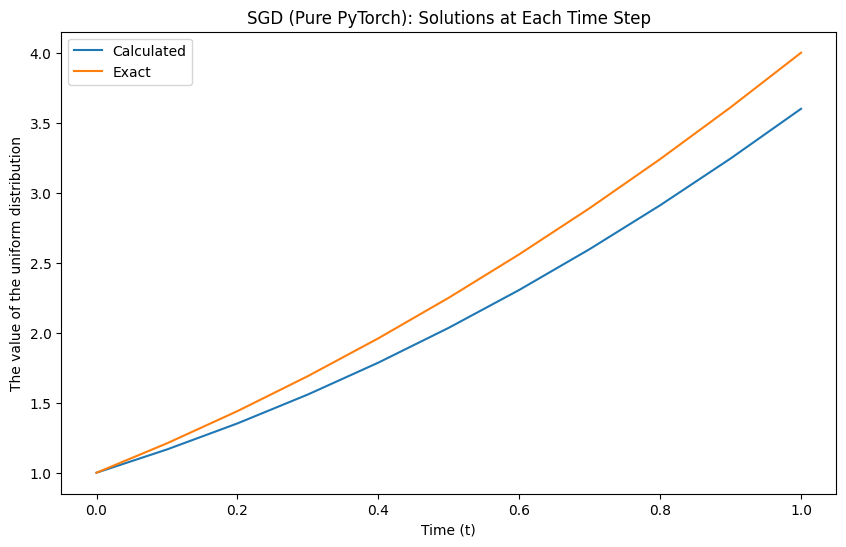

In [12]:
T = 10
N = 10
p1 = torch.ones(N)
p2 = 4*p1

wfr, p, v, z = wfr_grid(p1, p2, delta=1, rel=70, T=T, lr=1e-3)

print('WFR distance:', wfr)

# Convert the tensor to a NumPy array
data = p.numpy()

# Create the spatial grid
t = np.linspace(0, 1, T+1)  # Spatial points

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(t, p[:, 0], label = 'Calculated')
plt.plot(t, (t+1)**2, label = 'Exact')

plt.xlabel('Time (t)')
plt.ylabel('The value of the uniform distribution')
plt.title('SGD (Pure PyTorch): Solutions at Each Time Step')
plt.legend()
plt.show()

We note that there are `rel`s that gives the better results than the above. We use the same `rel` as below for comparison.

We now do the same using the scipy LBFGS. 

WFR distance: 1.4647174723824161


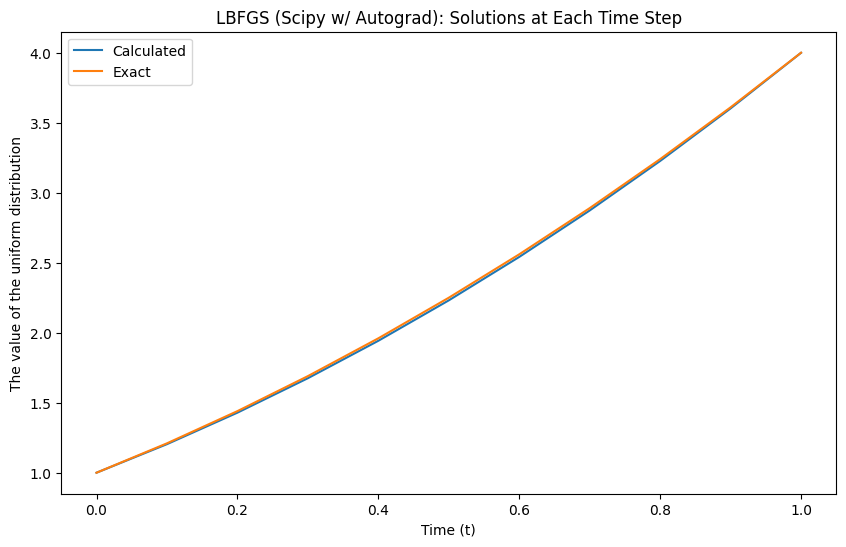

In [11]:
T = 10
N = 10
p1 = np.ones(N)
p2 = 4*p1

wfr, p, v, z = wfr_grid_scipy(p1,
                            p2, 
                            delta=1, 
                            rel=70, 
                            T=T)

print('WFR distance:', wfr)

# Convert the tensor to a NumPy array

# Create the spatial grid
t = np.linspace(0, 1, T+1)  # Spatial points

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(t, p[:, 0], label = 'Calculated')
plt.plot(t, (t+1)**2, label = 'Exact')

plt.xlabel('Time (t)')
plt.ylabel('The value of the uniform distribution')
plt.title('LBFGS (Scipy w/ Autograd): Solutions at Each Time Step')
plt.legend()
plt.show()

We will now investigate how we can tune the `rel` parameter. We gradually increase the `rel` parameter from 1 to 100 and see how the error between the exact solution changes.

91


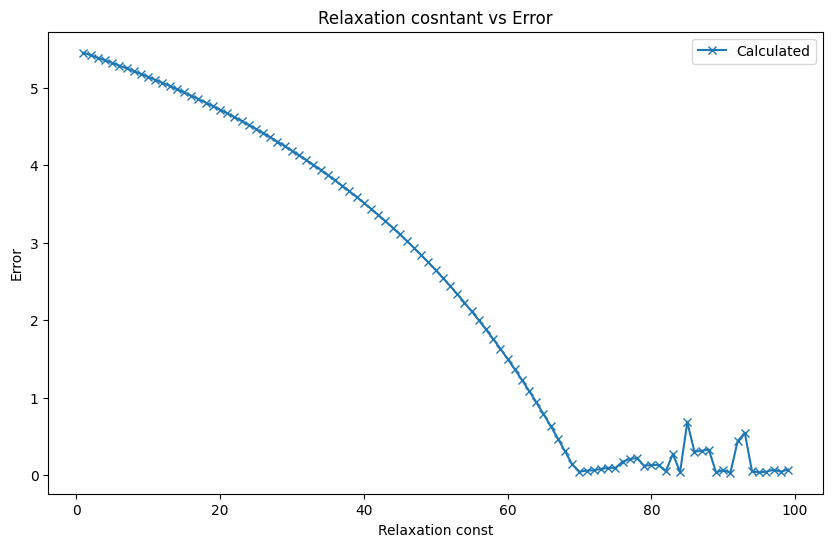

In [4]:
T = 10
N = 10
p1 = np.ones(N)
p2 = 4*p1

rels = np.arange(1,100, 1)
error = []

t = np.linspace(0, 1, T+1)
exact = (t+1)**2

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T)
    error.append(np.linalg.norm(p[:, 0]-exact))

min_ind = np.argmin(error)
print(rels[min_ind])

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, error, label = 'Calculated', marker='x')

plt.xlabel('Relaxation const')
plt.ylabel('Error')
plt.title('Relaxation cosntant vs Error')
plt.legend()
plt.show()

We note that the error monotonically decreases until it reaches the plateau, and then it oscilates. We will now see if we can observe the same phenomenon without using the exact solution. We plot the calculated WFR distance against the relaxation parameter.

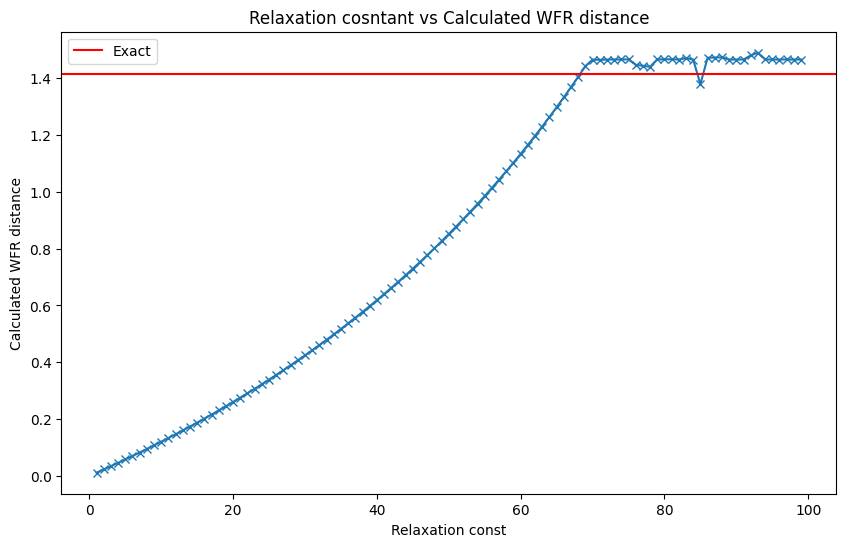

In [13]:
T = 10
N = 10
p1 = np.ones(N)
p2 = 4*p1

rels = np.arange(1,100,1)
wfrs = []

t = np.linspace(0, 1, T+1)
exact = (t+1)**2

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.axhline(y=np.sqrt(2), color='r', linestyle='-', label = 'Exact')

plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR distance')
plt.title('Relaxation cosntant vs Calculated WFR distance')
plt.legend()
plt.show()

We observe the same phenomenon with a quantity that does not require the outside knowledge. We can establish the tuning strategy from this. Namely, we increase the parameter until the calculated WFR stops increasing.

## Example 2: Translation of von-Mises distribution

The von-Mises distribution is a continuous distribution on $[0,2\pi]$ defined by the pdf

$\begin{equation} f(x|\mu,\kappa) = \frac{\exp(\kappa \cos(x-\mu))}{2\pi I_0(\kappa)}\end{equation}\tag*{}$

where $I_0(\kappa)$ is the modifed Bessel function of the first kind of order 0. This is often referred to as the normal distribution on a circle.

We first check if the WFR plateau also appears in this case.

In [14]:
from scipy.special import i0
def von_mises_pdf(x, mu, k):
    return np.exp(k*np.cos(x-mu))/(2*np.pi*i0(k))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


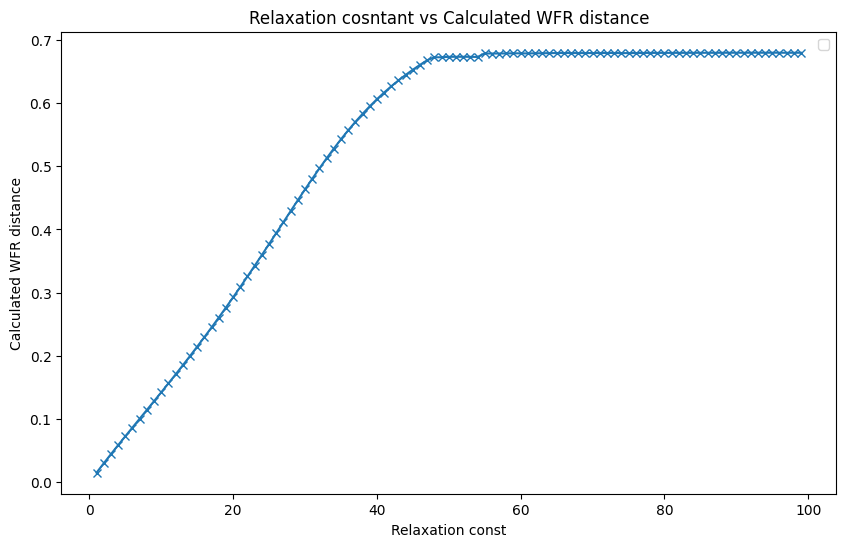

In [13]:
T = 10
N = 10
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)

rels = np.arange(1,100,1)
wfrs = []

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, dx=dx)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')

plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR distance')
plt.title('Relaxation cosntant vs Calculated WFR distance')
plt.legend()
plt.show()

Again we observe the plateau. We will now plot the solution at each time for `rel`=50.

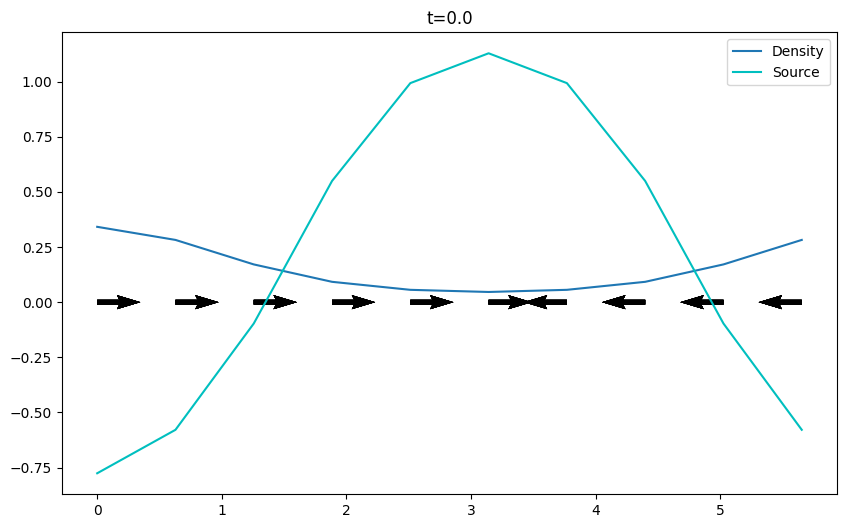

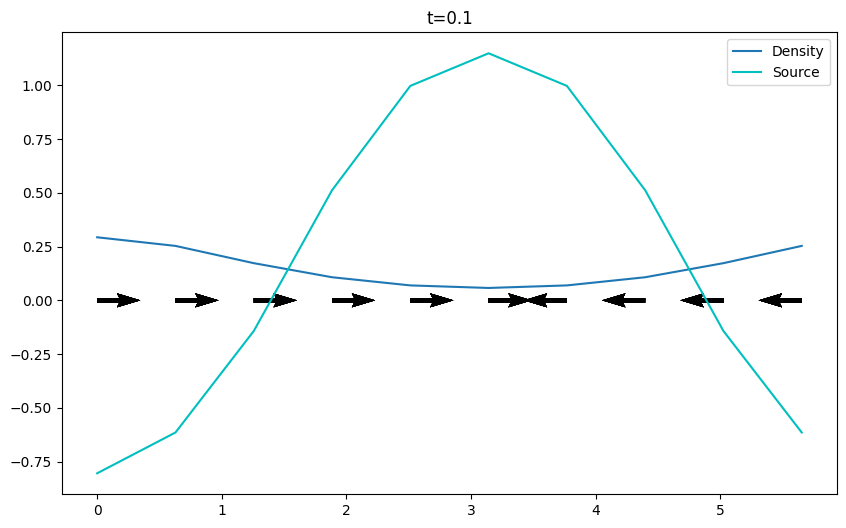

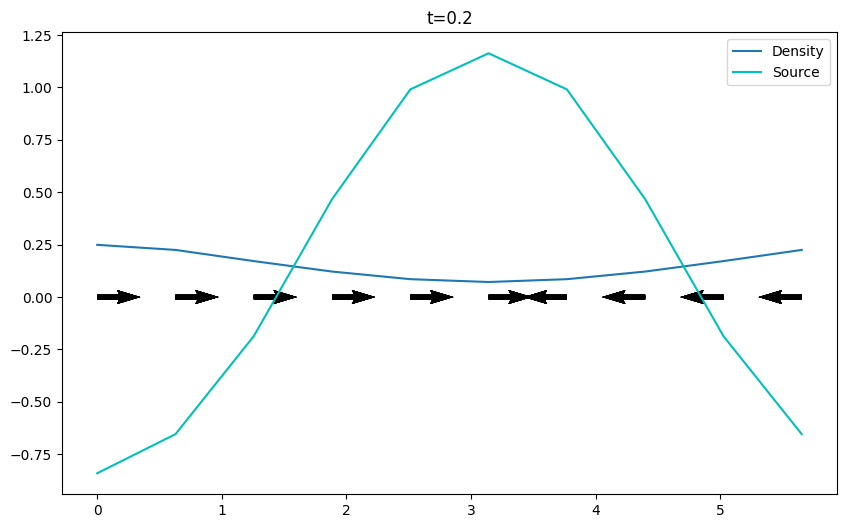

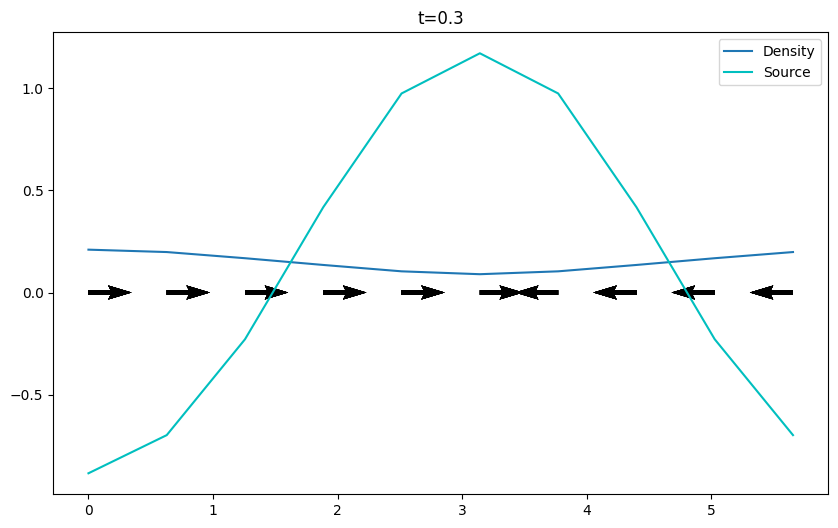

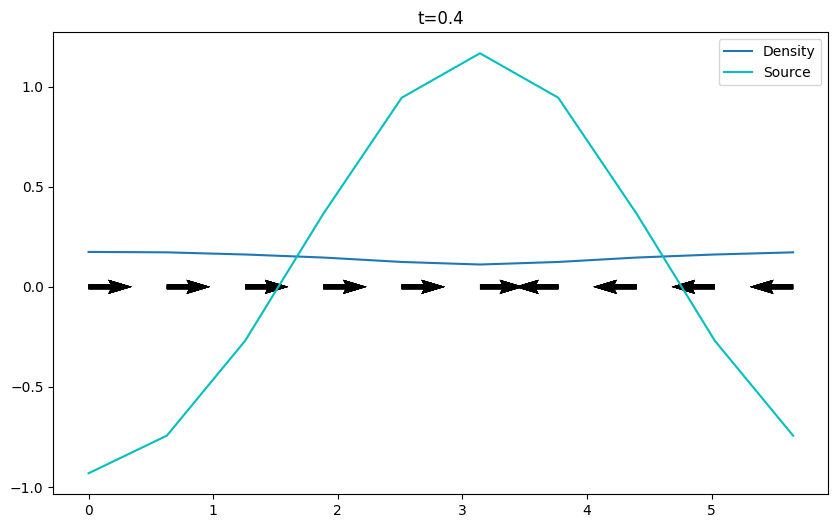

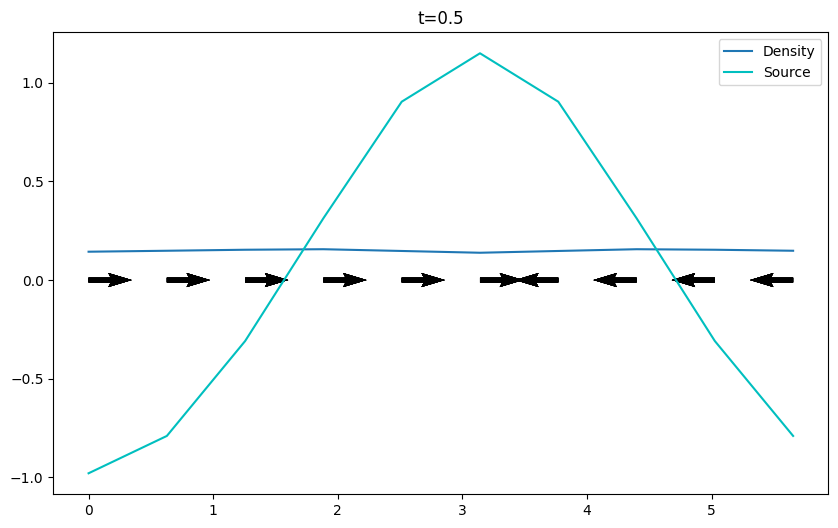

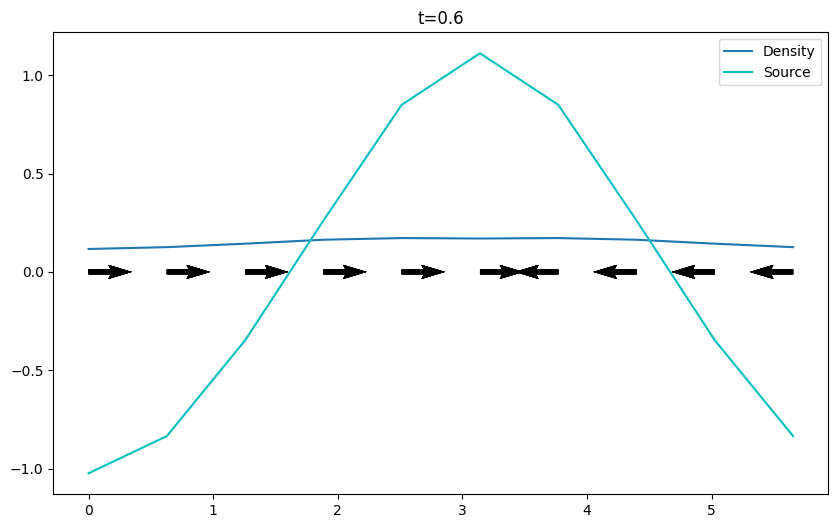

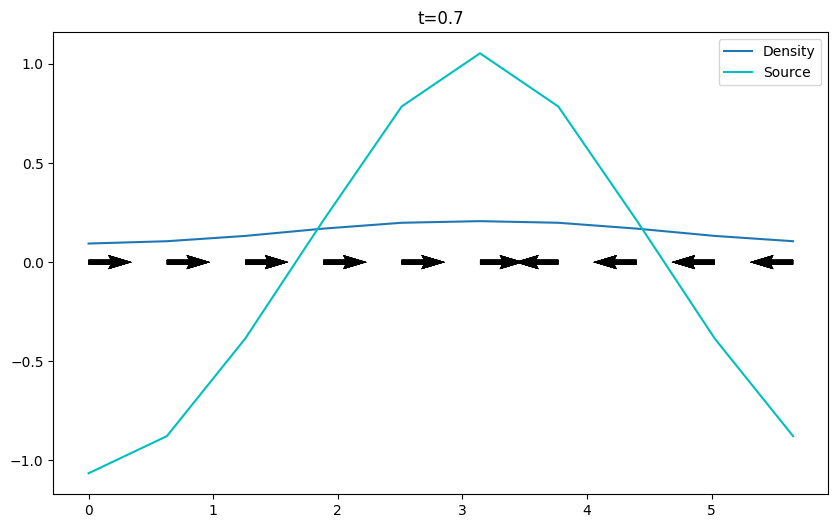

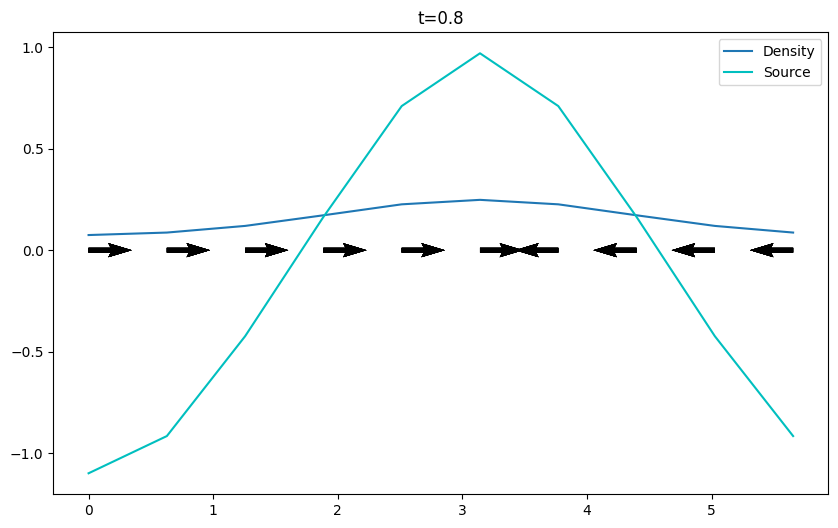

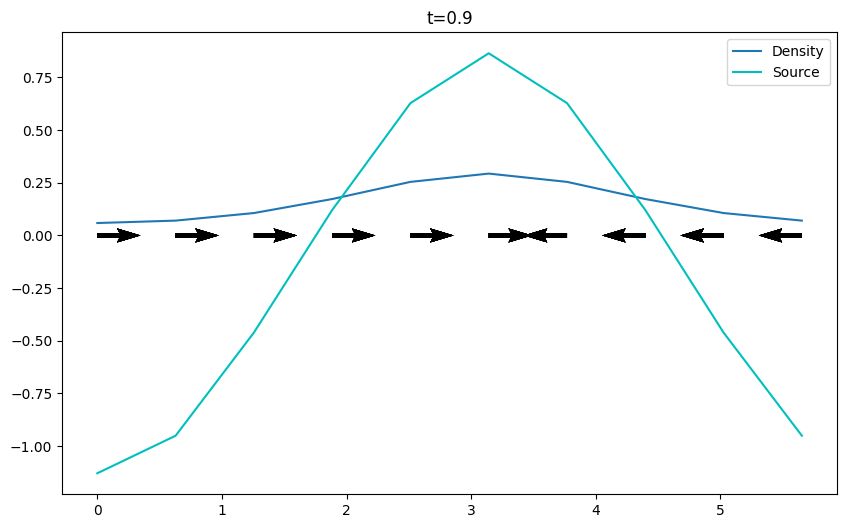

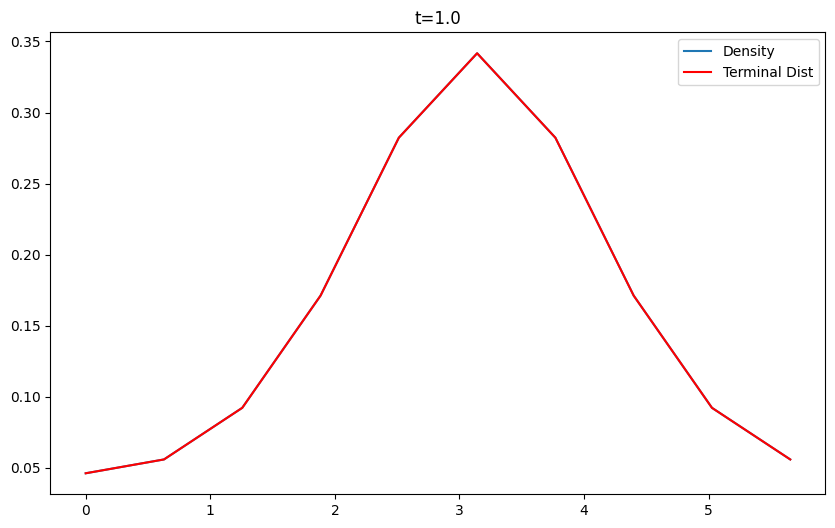

In [21]:
T = 10
N = 10
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)
wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=50, T=T, dx=dx)

# Plotting

plot_pvz_1D(p, v, z, dx=dx, p2 = p2)

# Example 2.1: Oscillating solution
Here, we take $N$ to be large and $T$ to be small to observe an oscillating solution originating from the violation of the CFL condition. 

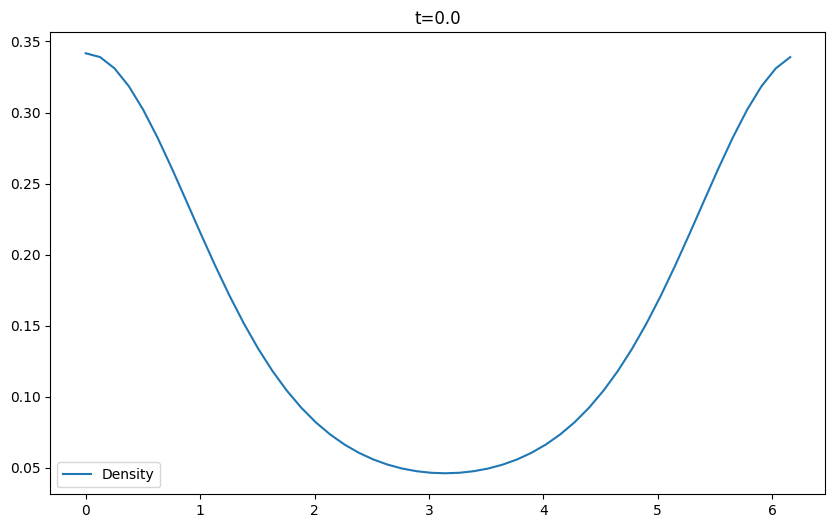

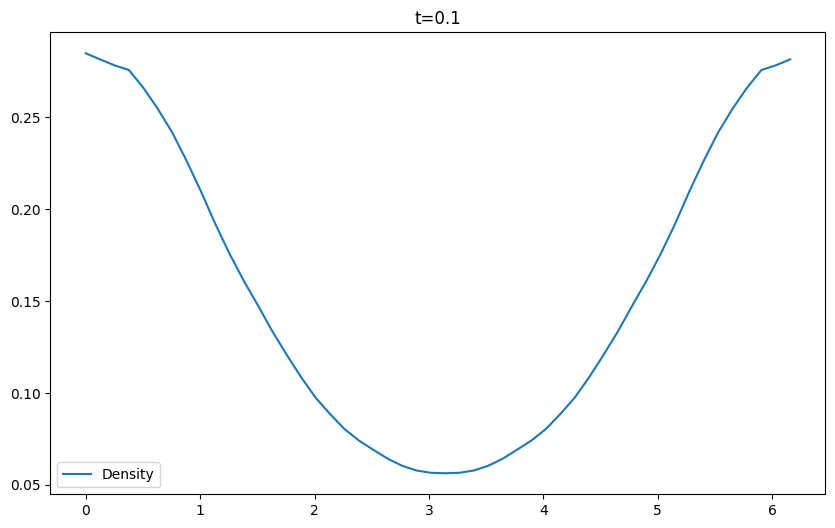

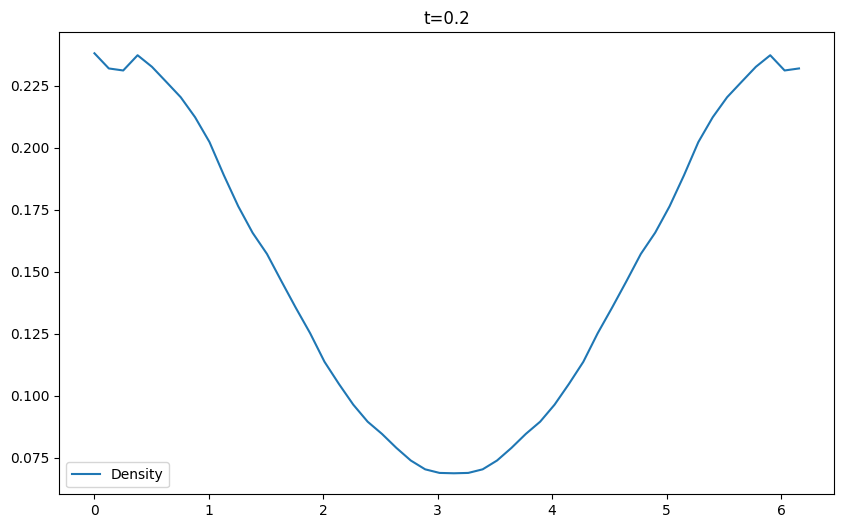

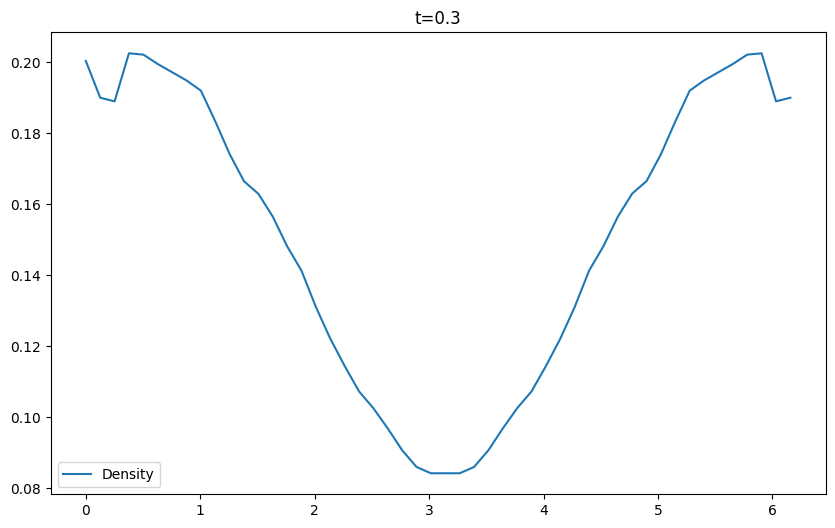

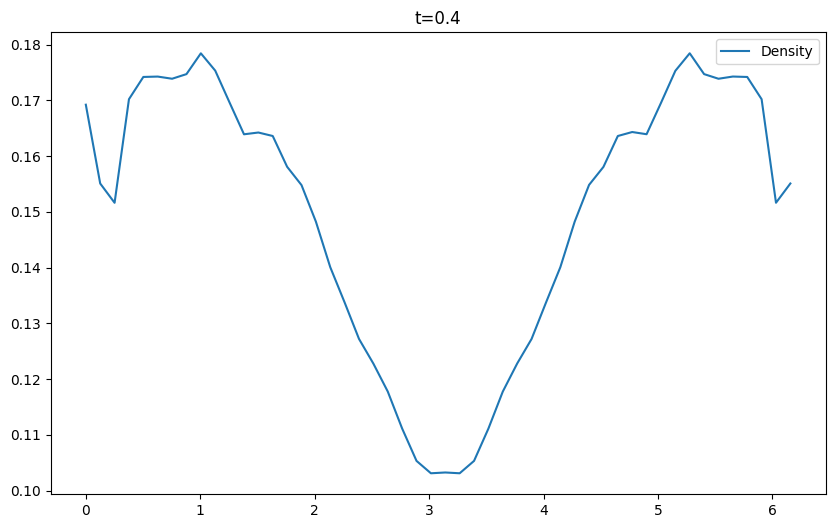

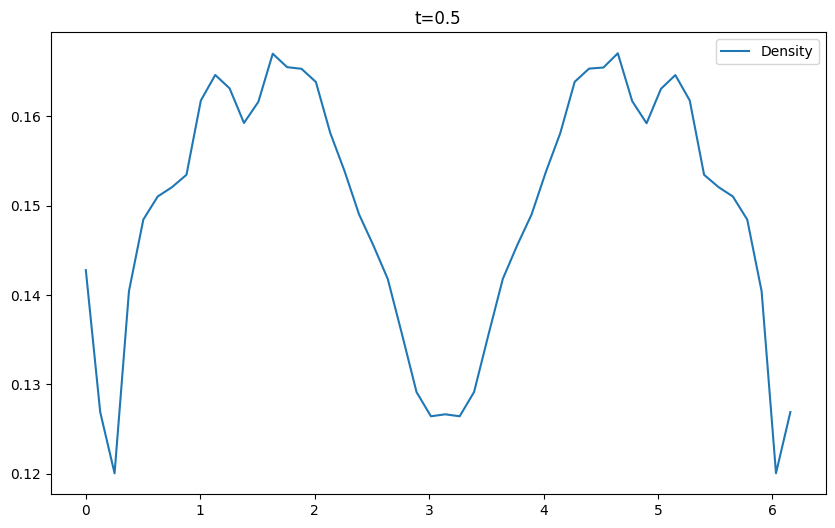

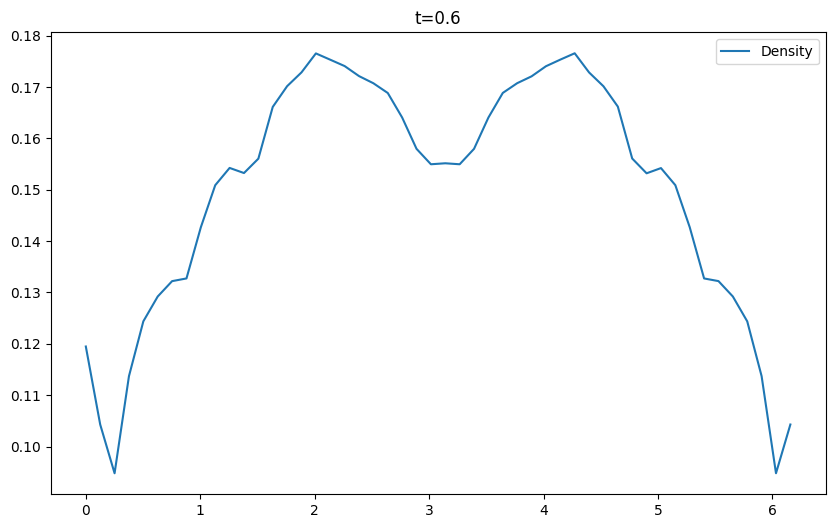

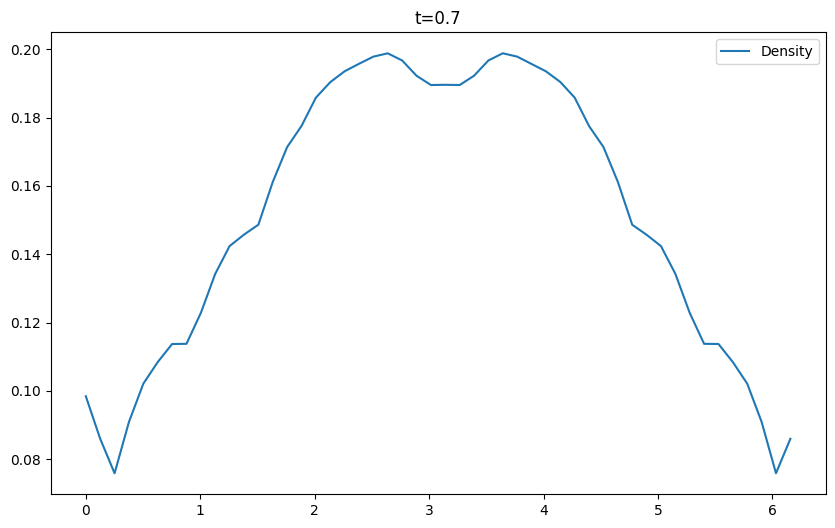

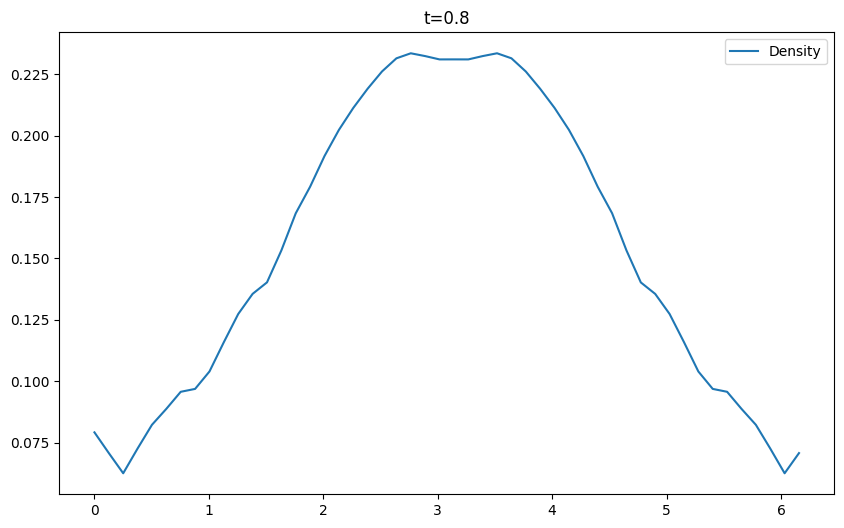

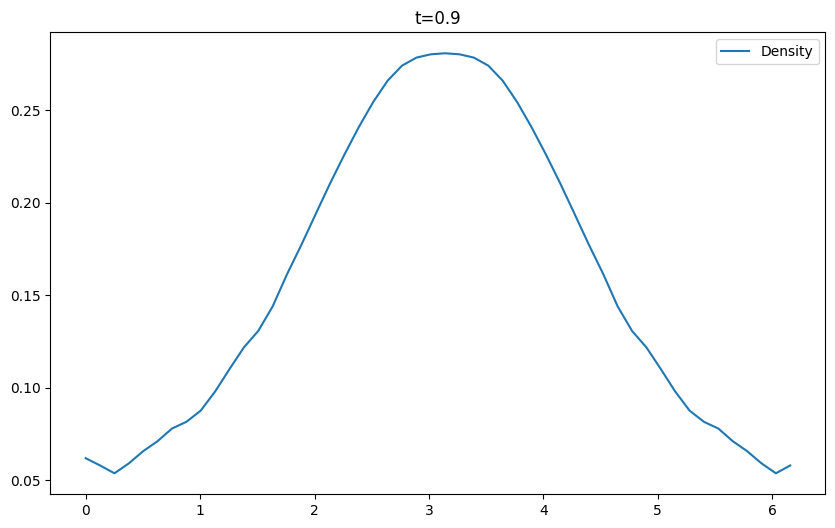

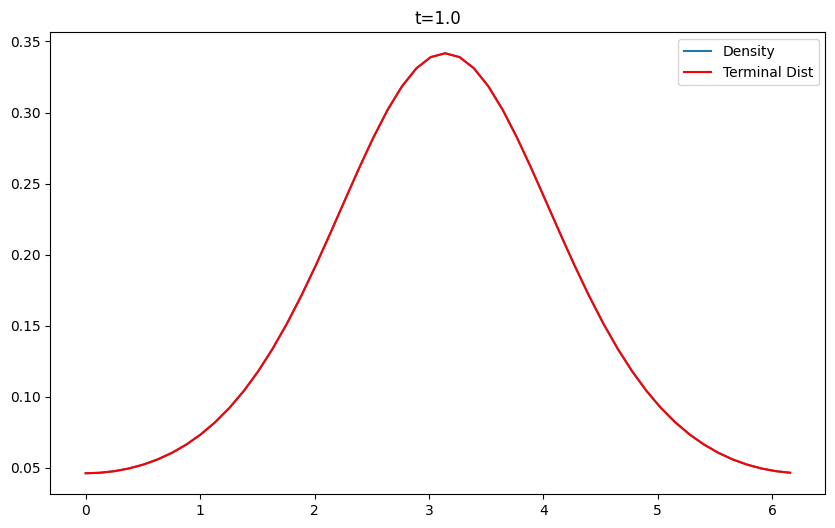

In [25]:
T = 10
N = 50
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)
wfr, p, v, z, best_rel = wfr_grid_scipy_tunerel(p1, p2, delta=1, rel_start=100, rel_stop=200, rel_step = 1, T=T, dx=dx)

# Plotting

plot_pvz_1D(p, None, None, dx=dx, p2 = p2)

# Example 3: Scaling with total mass constraint

Here, we do the same experiment as Example 1 under the total mass constraint $\rho_t(\Omega) = f(t)$. We interpolate the uniform distributions of mass $1$ and mass $4$, but under the constraint $\rho_t(\Omega)=f(t) = 6 \sin\left(\frac{5\pi}{6} t\right)+1$. 

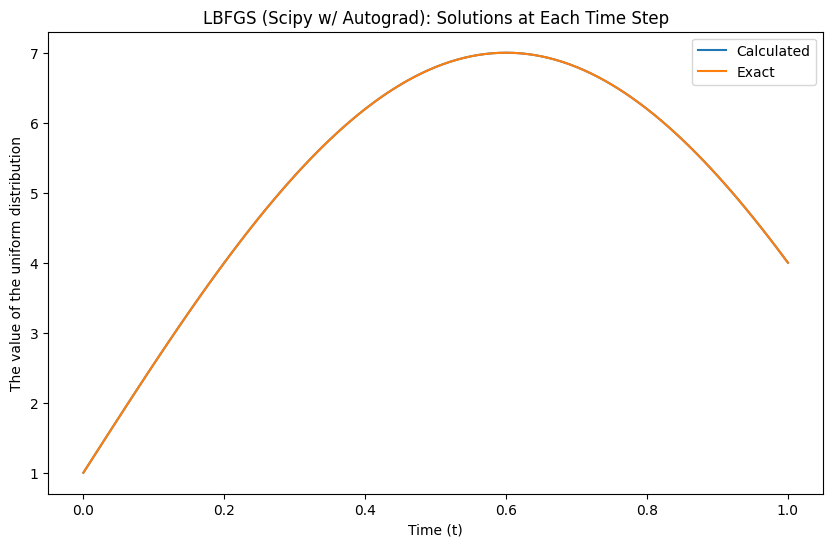

In [3]:
T = 100
N = 100
p1 = np.ones(N)
p2 = 4*np.ones(N)


t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 6*np.sin((5*np.pi/6)*t)+1

wfr, p, v, z, best_rel = wfr_grid_scipy_tunerel(p1, p2, delta=1, rel_start=1, rel_stop=10, rel_step = 1, T=T, H=H, F=F)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(t, p[:, 0], label = 'Calculated')
plt.plot(t, F, label = 'Exact')

plt.xlabel('Time (t)')
plt.ylabel('The value of the uniform distribution')
plt.title('LBFGS (Scipy w/ Autograd): Solutions at Each Time Step')
plt.legend()
plt.show()

We observe that the our calculated density matches well with the expected solution. We also observe an interesting phenomenon shown below.

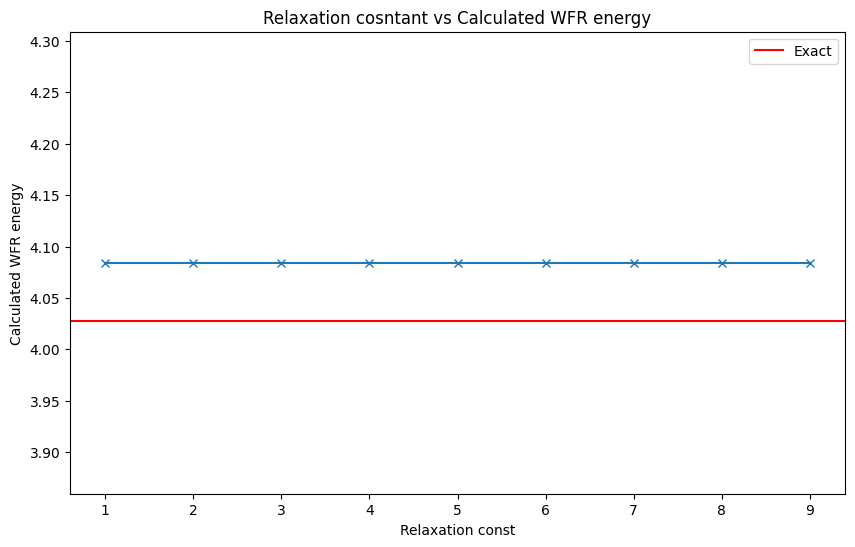

In [4]:
wfrs = []
rels = np.arange(1, 10, 1)

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.axhline(y=4.0275581885737655, color='r', linestyle='-', label = 'Exact')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.legend()
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

We observe that the calclated WFR is always the same regardless of the relaxation constant. We have also tested for a large range of `rel`, and still observed the same phenomenon. We believe it is because the constraint leaves no wiggle room for our `v`, `z` and end up being the same for all `rel`.

We will now check if the WFR energy converges to the exact solution as $T\to \infty$.

In [ ]:
wfrs = []
Ts = list(range(100,10000, 100))

for T in Ts:
    N = 10
    p1 = np.ones(N)
    p2 = 4*np.ones(N)

    t = np.linspace(0, 1, T+1)
    H = np.ones((T+1, N))
    F = 6*np.sin((5*np.pi/6)*t)+1

    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=1, T=T, H=H, F=F)
    wfrs.append(wfr)
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(Ts, wfrs, label = 'Calculated WFR')
plt.yscale('log')
plt.axhline(y=4.0275581885737655, color='r', linestyle='-', label = 'Exact')

plt.xlabel('T: The number of time steps')
plt.ylabel('Square root of the WFR energy')
plt.title('The number of time steps vs Calculated WFR')
plt.legend()
plt.show()
#19 min for all steps, 24.7 sec for T=10000, N=10

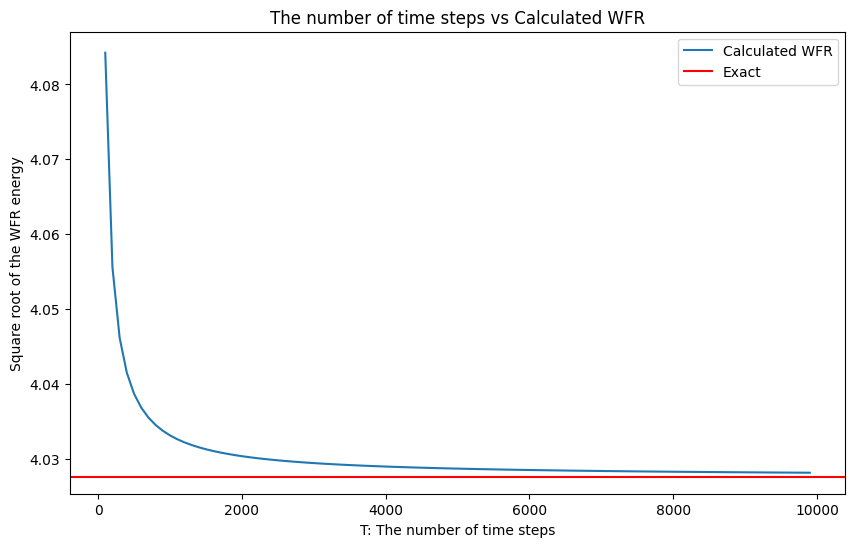

In [10]:
plt.figure(figsize=(10, 6))

plt.plot(Ts, wfrs, label = 'Calculated WFR')
plt.axhline(y=4.0275581885737655, color='r', linestyle='-', label = 'Exact')
plt.xlabel('T: The number of time steps')
plt.ylabel('Square root of the WFR energy')
plt.title('The number of time steps vs Calculated WFR')
plt.legend()
plt.show()

### Example 4: Scaling of von Mises with total mass constraint $\rho_t(\Omega) =2(t-1/2)^2+1/2$ (a U-shaped function)

To test our algorithm further, we consider the interpolation of the **same** von-Mises under the constraint above. We should have a nontrivial solution due to the constraint. In particular, the optimal sqrt energy should be 

$\begin{align}  \textrm{WFR}^{1,F}_\delta = \left(\frac{1}{2}\int_{0}^{1}\frac{F'(t)^2}{F(t)}dt \right)^{1/2}= \sqrt{4-\pi} \end{align} \tag*{}$

We first check the relationship between the optimal WFR and the relaxation constant.

In [ ]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = p1

wfrs = []
rels = np.arange(1, 100, 1)

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F)
    wfrs.append(float(wfr))

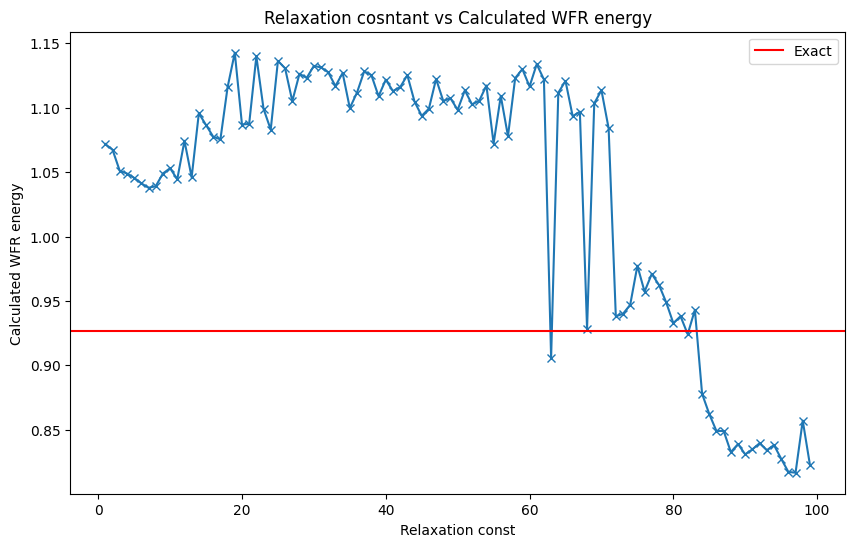

In [50]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.axhline(y=np.sqrt(4-np.pi), color='r', linestyle='-', label = 'Exact')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.legend()
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

We observe that there is a phase transition at around `rel`=60 and after the thereshold, the WFR energy drops below the exact value. To observe what happens after `rel=100`, we will continue this experiment below.

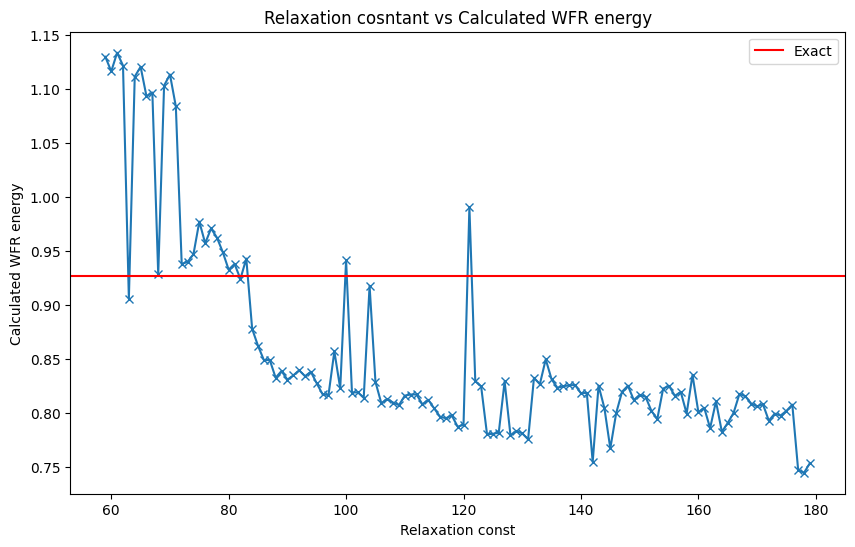

In [51]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = p1

wfrs = []
rels = np.arange(59, 180, 1)

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.axhline(y=np.sqrt(4-np.pi), color='r', linestyle='-', label = 'Exact')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.legend()
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

### Example 4.1: Transport of von Mises with total mass constraint $\rho_t(\Omega) = 2(t-1/2)^2+1/2$

Here, we consider the interpolation of the von-Mises distributions with the same total mass and the different center under the constraint above.

We first plot the square root of the optimal WFR energy against the relaxation constant to see if it still shows the "plateau" behavior.

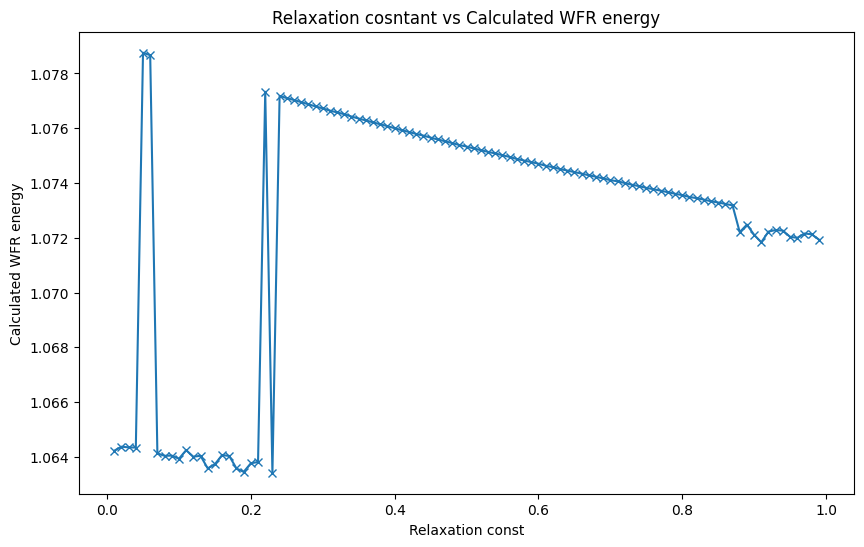

In [38]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)

wfrs = []
rels = np.arange(0.01, 1, 0.01)

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

We observe that the constrained matching shows a different pattern in this scale. Let's see the behavior in a larger scale.

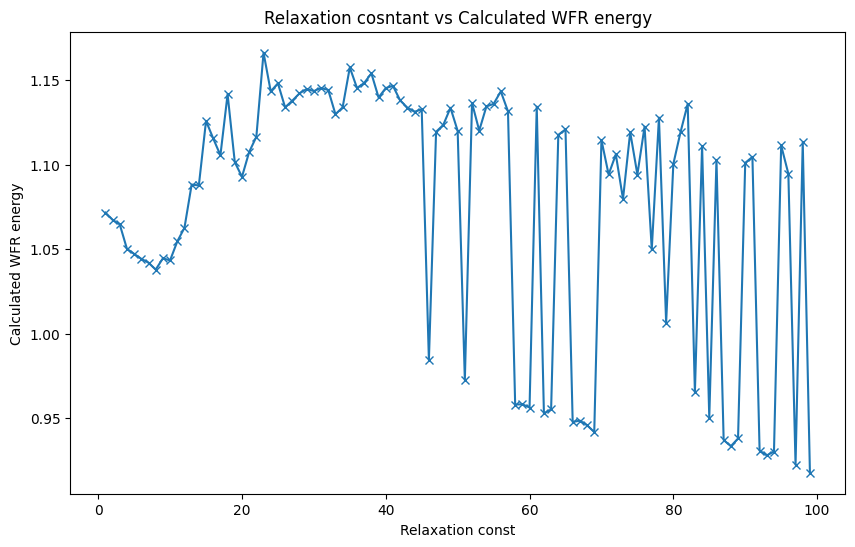

In [39]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)

wfrs = []
rels = np.arange(1, 100, 1)

for rel in rels:
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=rel, T=T, H=H, F=F)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

We observe that the WFR distance oscilates in a certain range, and again, there is no 'plateau' behavior. We will take the relaxation constant right before the oscillation starts i.e. `rel`=40.

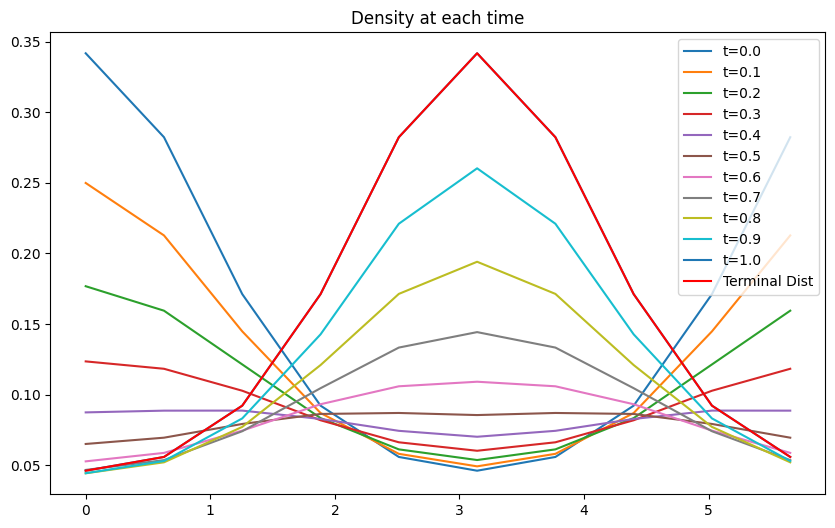

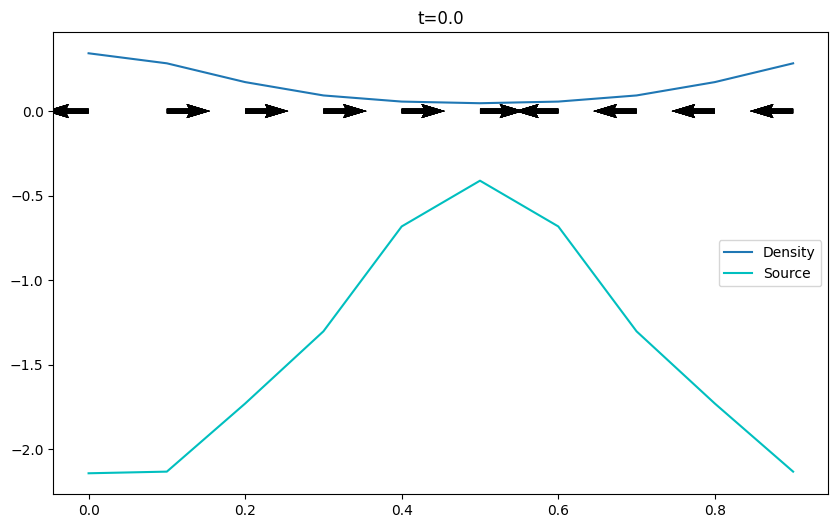

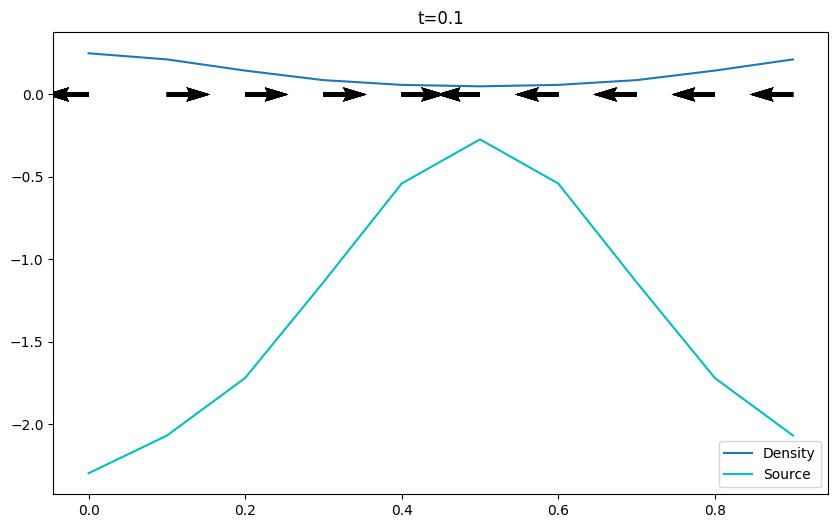

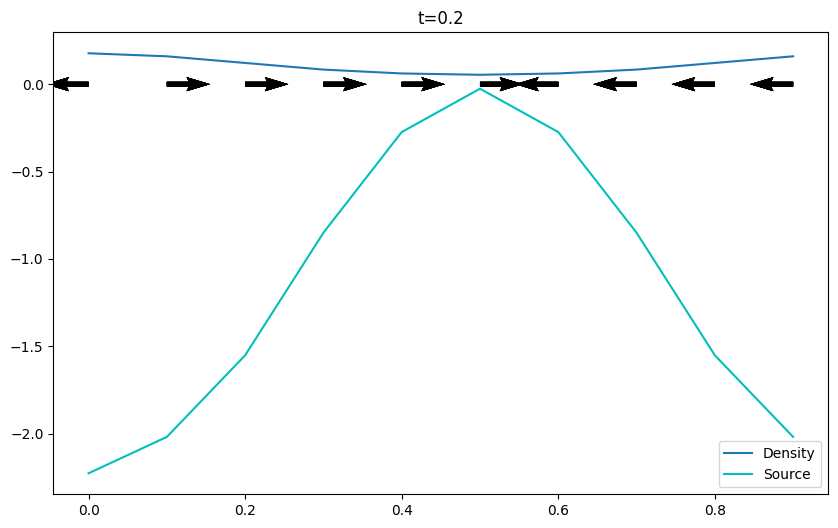

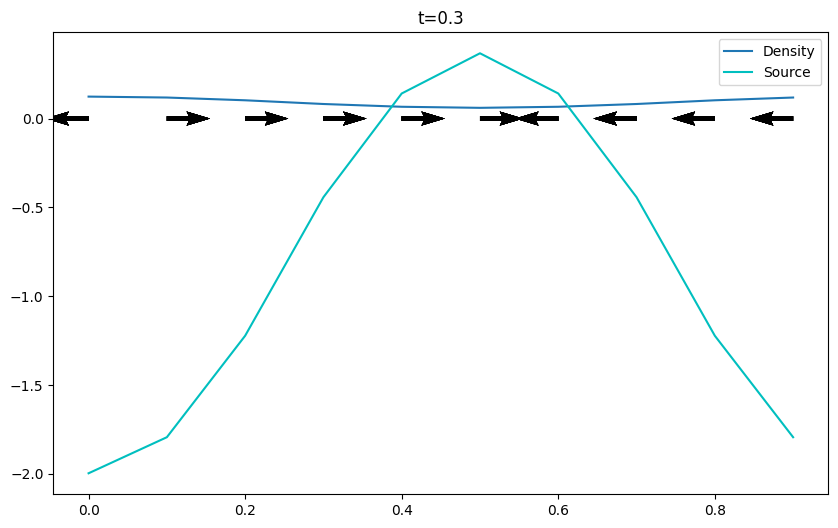

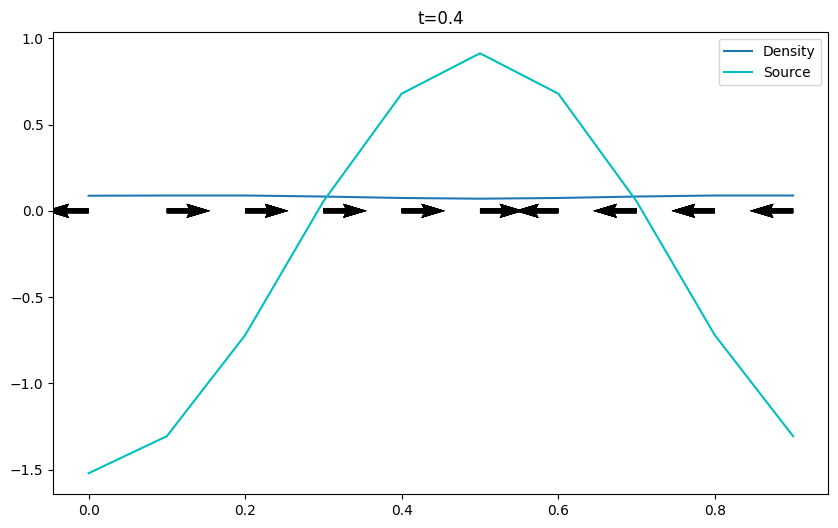

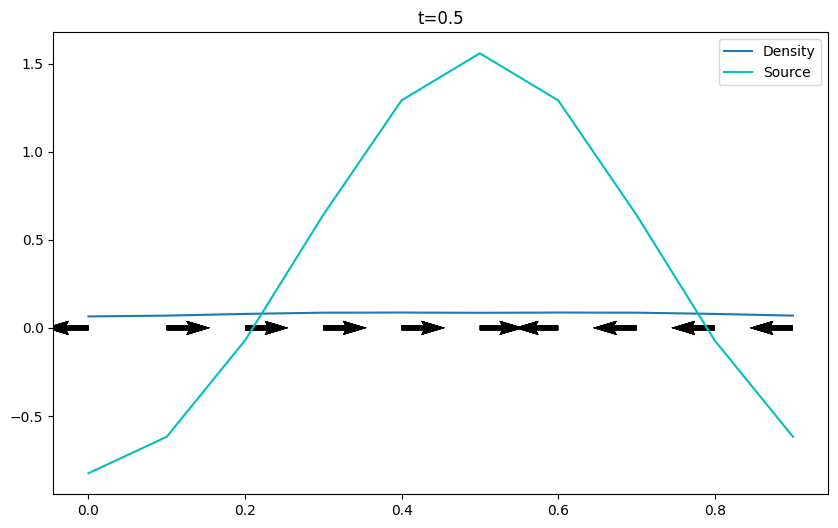

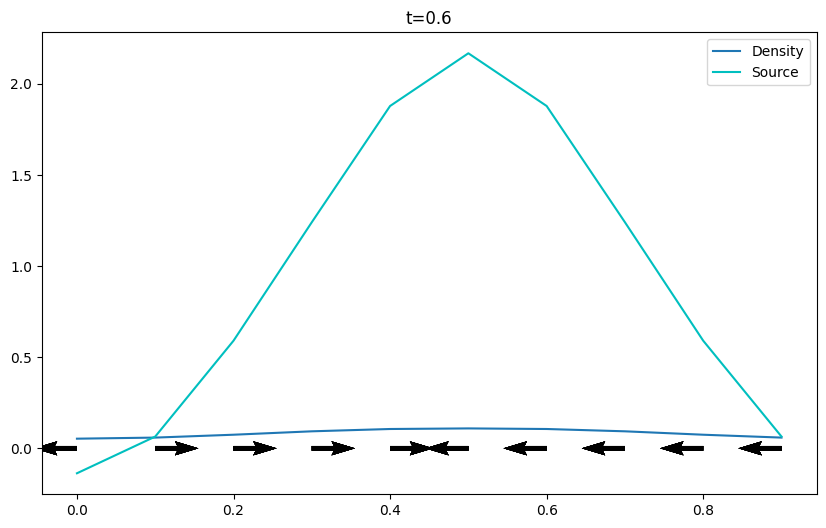

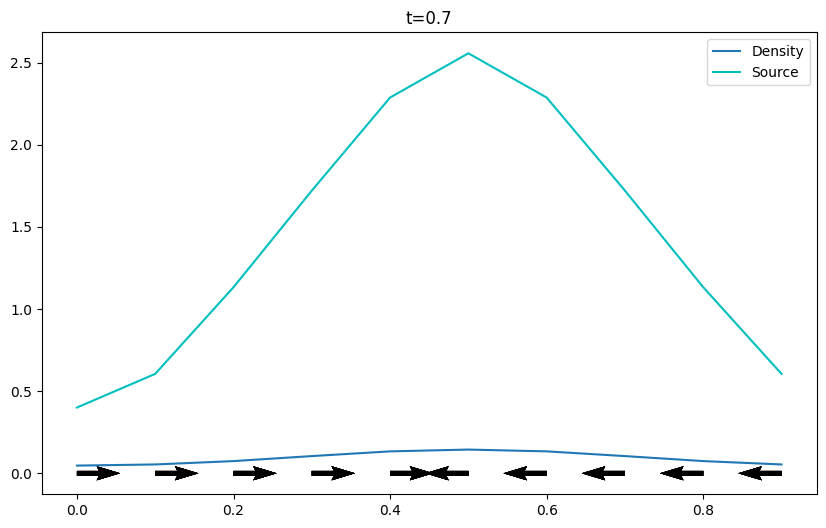

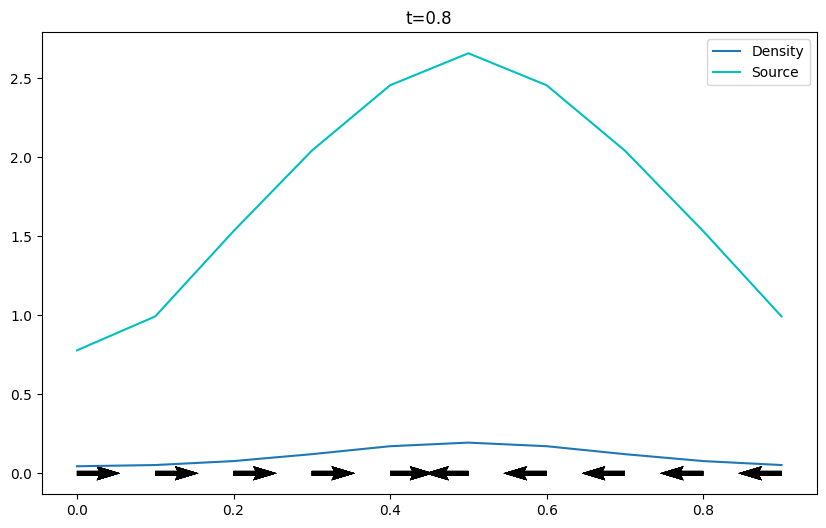

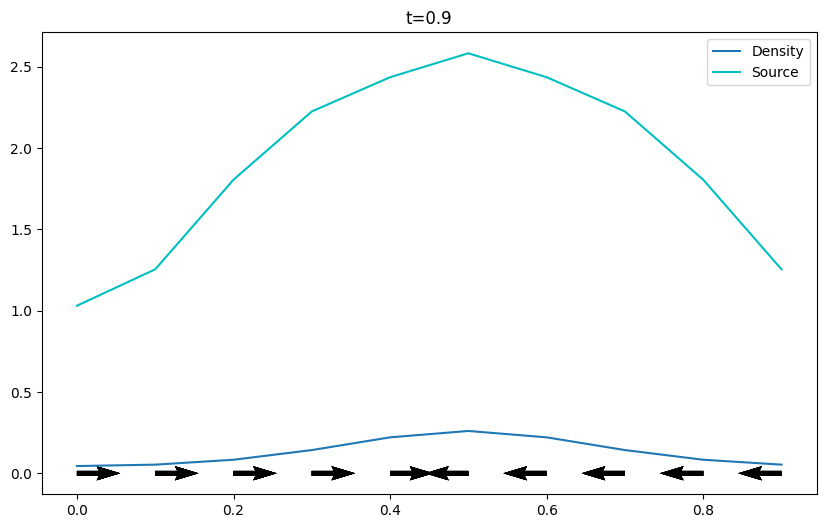

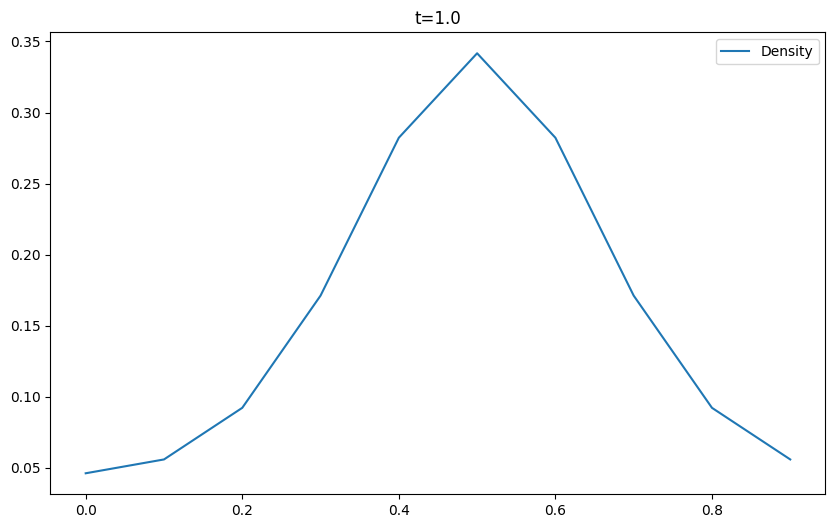

In [47]:
T = 10
N = 10
t = np.linspace(0, 1, T+1)
H = np.ones((T+1, N))
F = 2*(t-0.5)**2+0.5
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = von_mises_pdf(xs, np.pi, 1)
wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=1, rel=40, T=T, dx=dx, H=H, F=F)

# Plotting
plot_p_1D_same(p, dx=dx, p2 = p2)
plot_pvz_1D(p, v, z)

### Example 5: The balanced transport with source. Verification of the conjecture.

Here, we consider the constraint $\rho_t(\Omega) =1$. In particular, we would like to verify the conjecture that the optimal path between two Diracs at $x_0,x_1$ with $\|x_0-x_1\|> \pi\delta$ is the constrained FR geodesic $\rho = (a(t)\delta_{x_0} + b(t)\delta_{x_1})$ with

$\begin{align} a(t) & = \cos^2\left(\frac{\pi}{2}t\right) \\ b(t) & = \sin^2\left(\frac{\pi}{2}t\right)\end{align} $

Due to the limitation of our method, it is not possible to directly interpolate Dirac measures, so we will use sharp ($\kappa=10$) von-Mises as their proxy. We also take $\delta=0.1$ instead of $1$ we have been using to make sure no transport occurs.

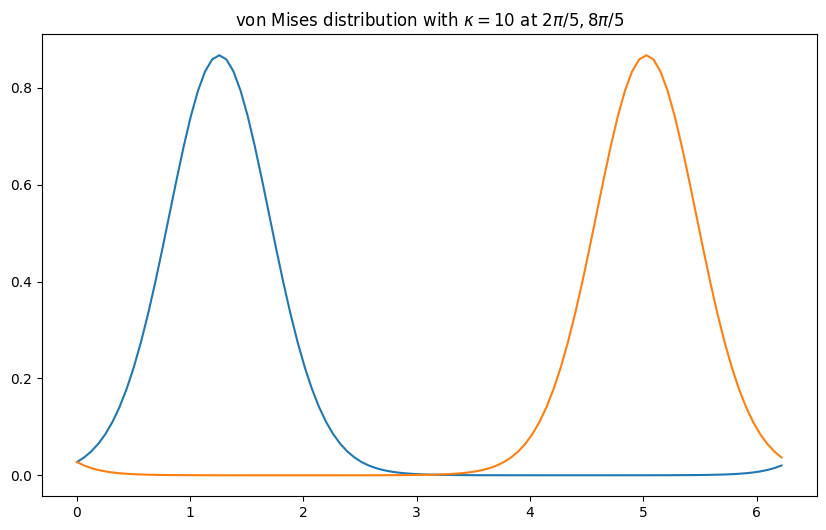

In [117]:
N=100
xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 2*np.pi/5, 5)
p2 = von_mises_pdf(xs, 8*np.pi/5, 5)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(xs, p1)
plt.plot(xs, p2)
plt.title('von Mises distribution with $\kappa=10$ at $2\pi/5, 8\pi/5$')
plt.show()

We first see the relationship between WFR and the relaxation constant.


rels: 1
rels: 2
rels: 3
rels: 4
rels: 5
rels: 6
rels: 7
rels: 8
rels: 9
rels: 10
rels: 11
rels: 12
rels: 13
rels: 14
rels: 15
rels: 16
rels: 17
rels: 18
rels: 19
rels: 20
rels: 21
rels: 22
rels: 23
rels: 24
rels: 25
rels: 26
rels: 27
rels: 28
rels: 29
rels: 30
rels: 31
rels: 32
rels: 33
rels: 34
rels: 35
rels: 36
rels: 37
rels: 38
rels: 39
rels: 40
rels: 41
rels: 42
rels: 43
rels: 44
rels: 45
rels: 46
rels: 47
rels: 48
rels: 49
rels: 50
rels: 51
rels: 52
rels: 53
rels: 54
rels: 55
rels: 56
rels: 57
rels: 58
rels: 59
rels: 60
rels: 61
rels: 62
rels: 63
rels: 64
rels: 65
rels: 66
rels: 67
rels: 68
rels: 69
rels: 70
rels: 71
rels: 72
rels: 73
rels: 74
rels: 75
rels: 76
rels: 77
rels: 78
rels: 79
rels: 80
rels: 81
rels: 82
rels: 83
rels: 84
rels: 85
rels: 86
rels: 87
rels: 88
rels: 89
rels: 90
rels: 91
rels: 92
rels: 93
rels: 94
rels: 95
rels: 96
rels: 97
rels: 98
rels: 99


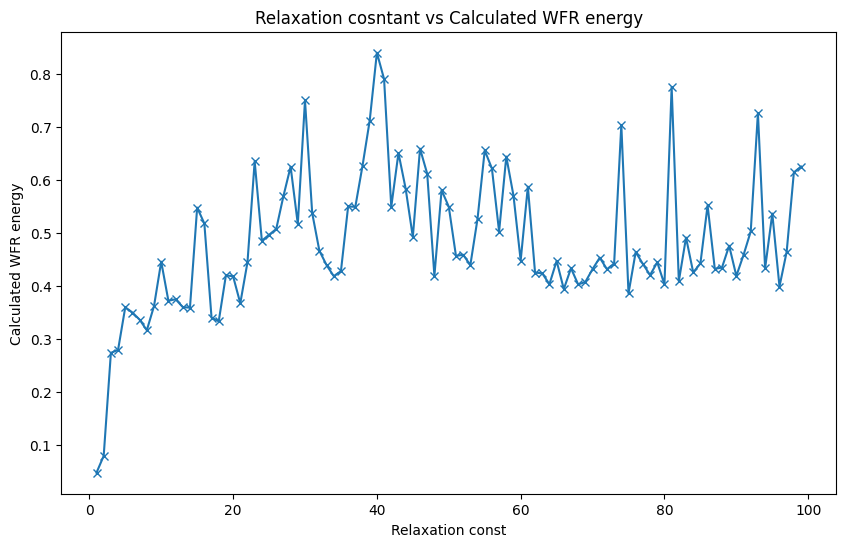

In [101]:
T = 10
N = 10
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 2*np.pi/5, 10)
p2 = von_mises_pdf(xs, 8*np.pi/5, 10)

wfrs = []
rels = np.arange(1, 100, 1)
for rel in rels:
    print('rels:', rel)
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=0.1, rel=rel, T=T, H=H, F=F, dx=dx)
    wfrs.append(float(wfr))

# Plottinga
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

In [124]:
T = 500
N = 50
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 2*np.pi/5, 5)+0.2 # avoid having zero density
p2 = von_mises_pdf(xs, 8*np.pi/5, 5)+0.2 # avoid having zero density

wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=0.1, rel=5000, T=T, H=H, F=F, dx=dx)

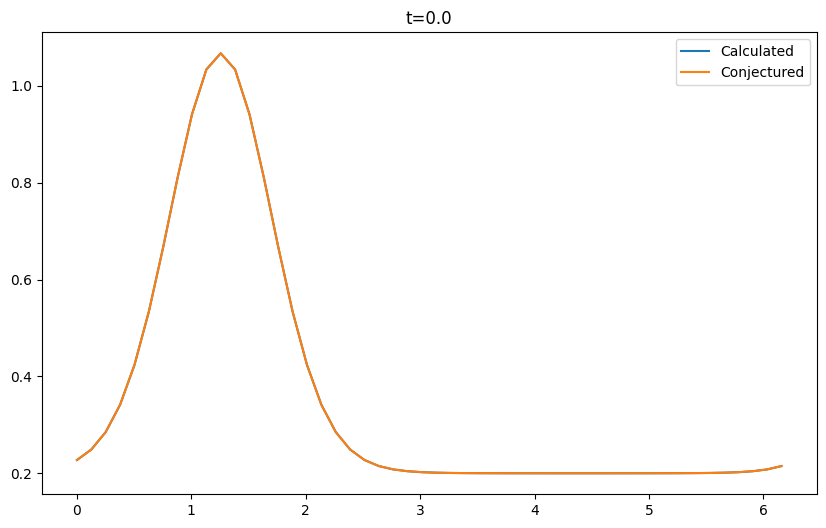

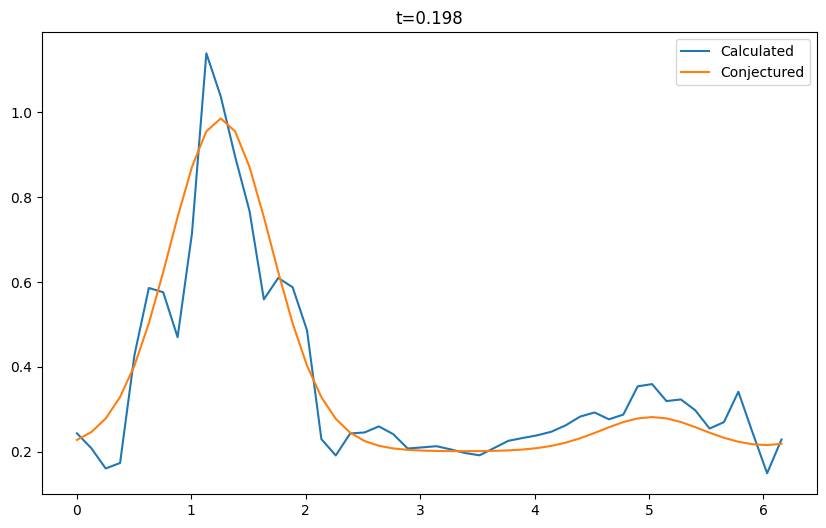

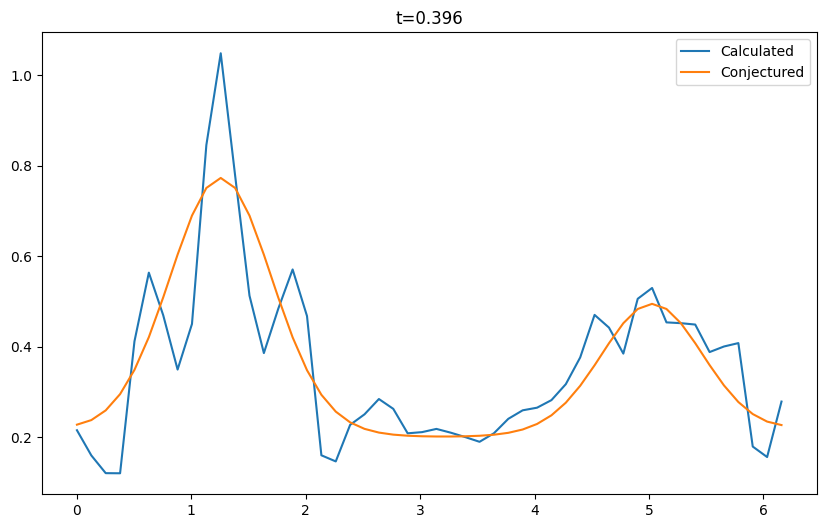

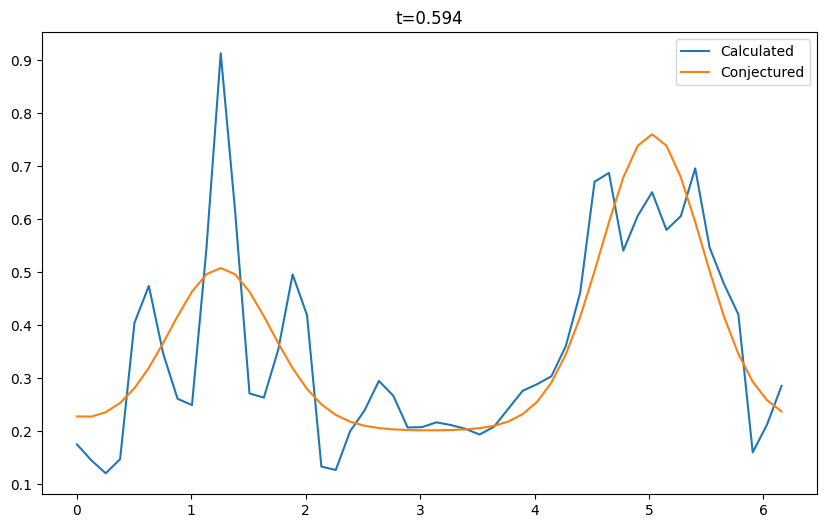

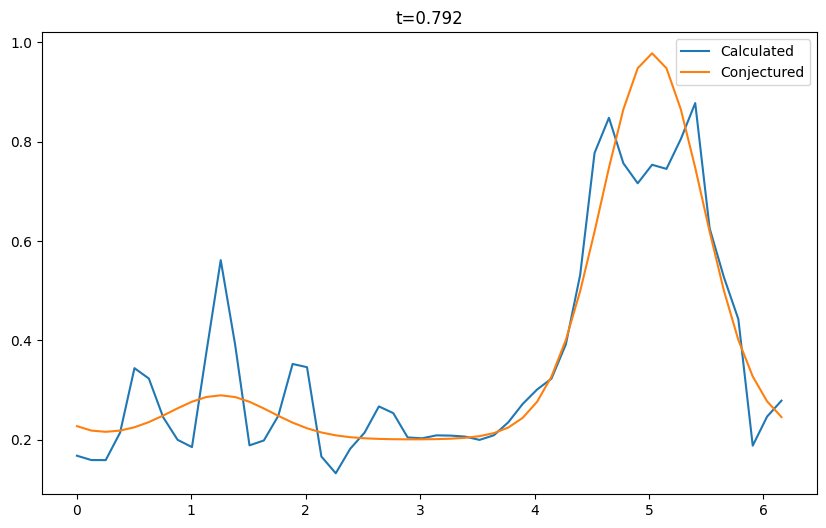

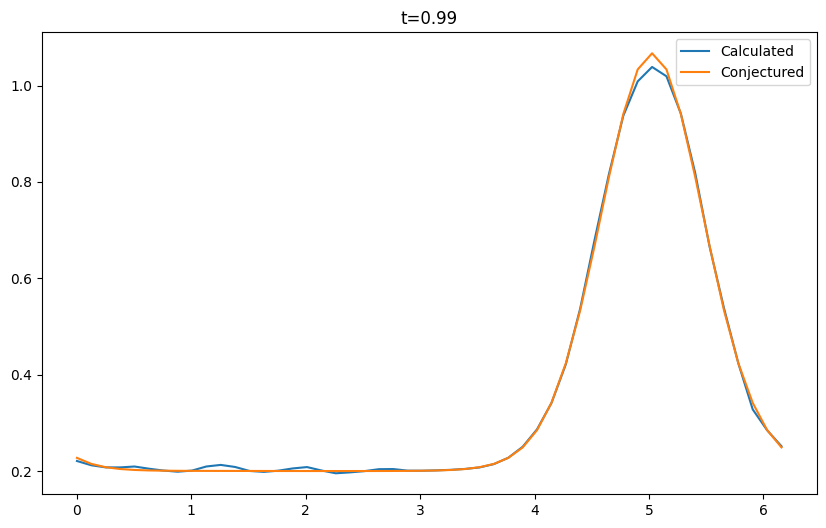

In [126]:
time_steps = p.shape[0]
space_steps = p.shape[-1]

for time_step in range(0, time_steps, 99):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    plt.plot(xs, p1*np.cos(np.pi*time/2.)**2+p2*np.sin(np.pi*time/2.)**2, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()

rels: 0.01
rels: 0.1
rels: 1
rels: 10
rels: 100
rels: 1000
rels: 2000
rels: 3000
rels: 4000
rels: 5000
rels: 6000
rels: 7000
rels: 8000
rels: 9000
rels: 10000


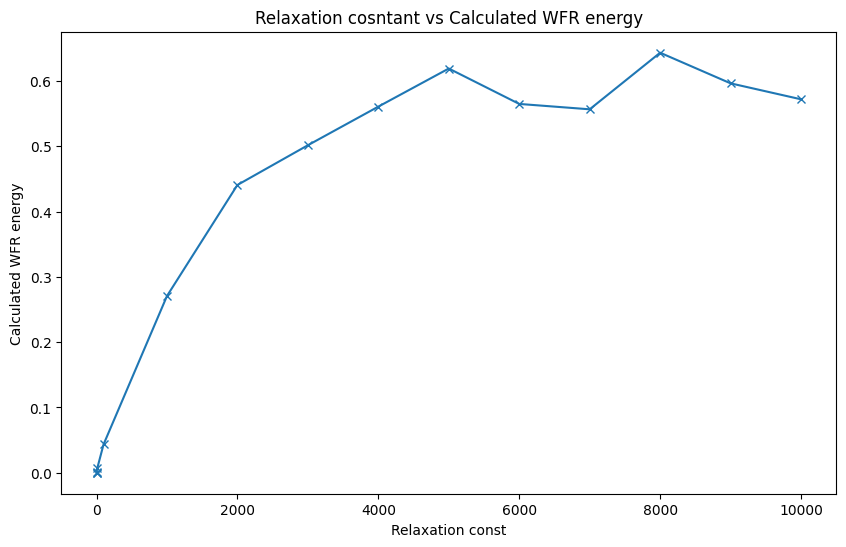

In [127]:
T = 500
N = 50
H = np.ones((T+1, N))
F = np.ones((T+1,))
dx = [2*np.pi/N]

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 2*np.pi/5, 10)
p2 = von_mises_pdf(xs, 8*np.pi/5, 10)

wfrs = []
rels = [0.01, 0.1, 1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
for rel in rels:
    print('rels:', rel)
    wfr, p, v, z = wfr_grid_scipy(p1, p2, delta=0.1, rel=rel, T=T, H=H, F=F, dx=dx)
    wfrs.append(float(wfr))

# Plottinga
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR energy')
plt.title('Relaxation cosntant vs Calculated WFR energy')

plt.show()

#201min

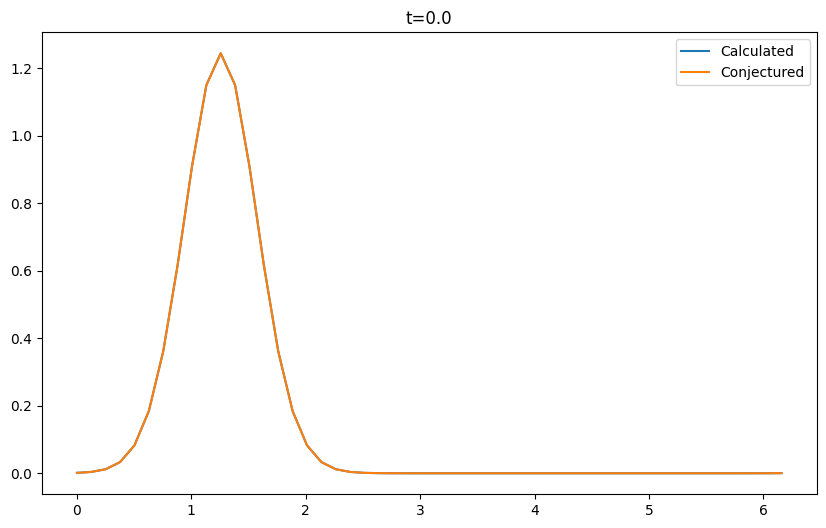

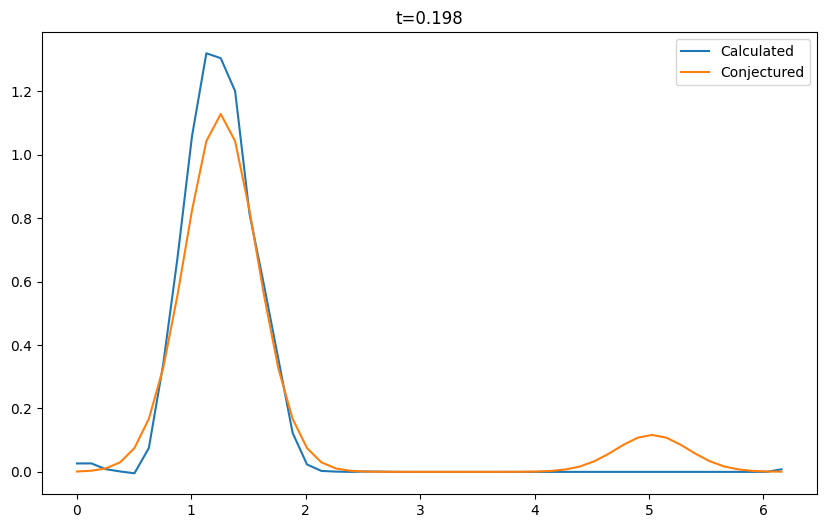

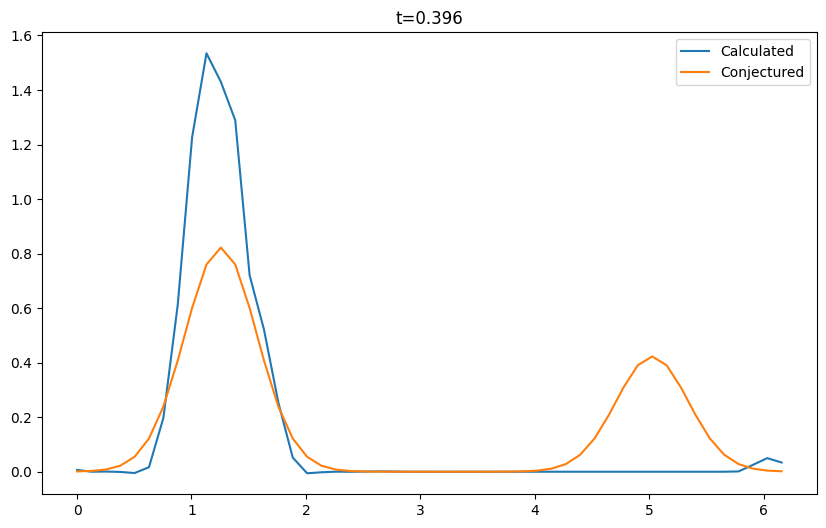

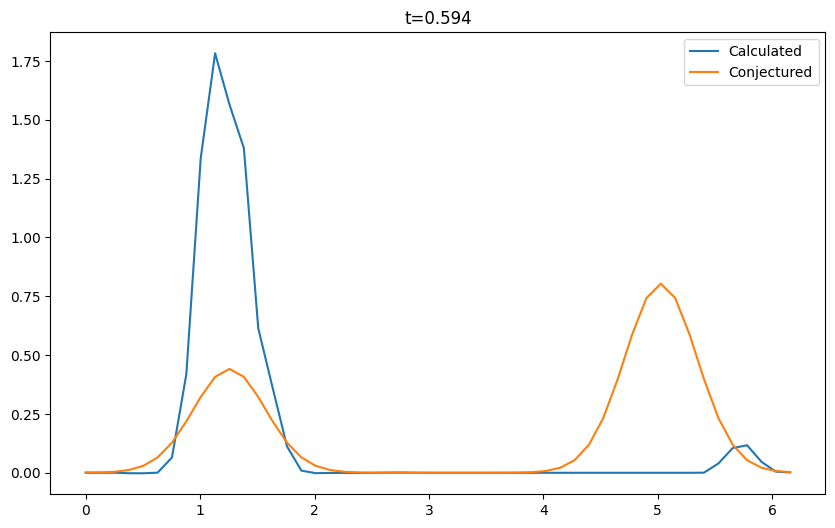

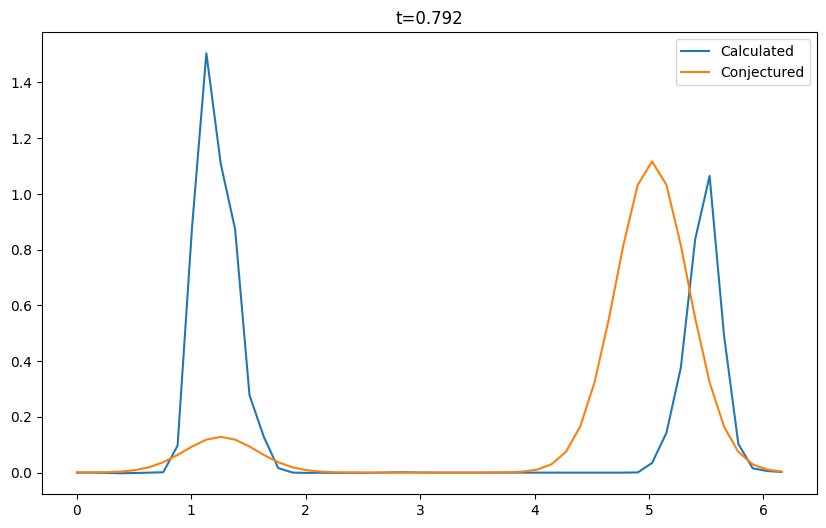

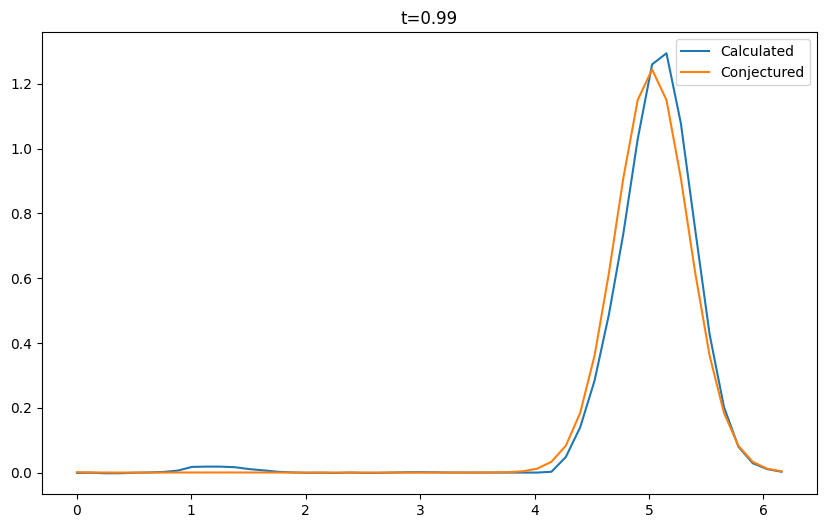

In [128]:
time_steps = p.shape[0]
space_steps = p.shape[-1]

for time_step in range(0, time_steps, 99):
    plt.figure(figsize=(10, 6))
    time = time_step/(time_steps-1)
    plt.plot(xs, p[time_step], label = 'Calculated')
    plt.plot(xs, p1*np.cos(np.pi*time/2.)**2+p2*np.sin(np.pi*time/2.)**2, label = 'Conjectured')
    plt.title(f't={time}')
    plt.legend()
    plt.show()